
# <center>Sendy Logistics</center>

Sendy is a business-to-business platform established in 2014, to enable businesses of all types and sizes to transport goods more efficiently across East Africa.

The company is headquartered in Kenya with a team of more than 100 staff, focused on building practical solutions for Africa’s dynamic transportation needs, from developing apps and web solutions, to providing dedicated support for goods on the move.

Currently operating in Kenya and Uganda, Sendy is expanding to Nigeria and Tanzania, to enable thousands more businesses to move volumes of goods easily, anywhere, at any time. Sendy aggregates a pool of delivery options from 28 ton, 14 ton, 5 ton trucks to pick up trucks, vans and motorcycles.

<p><img src="./image/Sendy-delivery-1200x500.jpg" alt="Sendy Logistics Logo"></p>


Sendy Logistics has realised that data is a critical component that can aid in building more efficient, affordable and accessible solutions as such they are interested in using data to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination. 

The solution will help Sendy enhance customer communication and the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business through improved resource management and planning for order scheduling.

To help Sendy achieve this goal we will build a predictive model that will predict estimated time of delivery of orders by looking at all factors that could influence the time from pick up to arrival of an order such as distance, date, the rider delivering the order etc.

## Importing the libraries ##
- We going to use the numpy libraries to use numpy arrays 
- We going to use pandas to load, merge  and modify our dataset
- matplotlib and seaborn libraries are going to be used to plot the model 

In [15]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr



## Loading the dataset ##

- **Pandas** is used to load the datafiles into our workspace
- four datafiles were loaded named Riders, Test,Train as well as VariableDefinitions

- Train.csv contains  Sendy historic data of orders with 28 features, this is the data we will use to train our model
- Test.csv contains  Sendy historic data of orders with 24 features, this is the data we will use to test our model
- Riders.csv contains information of riders that make the deliveries


In [16]:
riders = pd.read_csv("./regression data/Riders.csv")
test = pd.read_csv("./regression data/Test.csv")
train = pd.read_csv("./regression data/Train.csv")
variableDefinitions= pd.read_csv("./regression data/VariableDefinitions.csv")

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
Order No                                     21201 non-null object
User Id                                      21201 non-null object
Vehicle Type                                 21201 non-null object
Platform Type                                21201 non-null int64
Personal or Business                         21201 non-null object
Placement - Day of Month                     21201 non-null int64
Placement - Weekday (Mo = 1)                 21201 non-null int64
Placement - Time                             21201 non-null object
Confirmation - Day of Month                  21201 non-null int64
Confirmation - Weekday (Mo = 1)              21201 non-null int64
Confirmation - Time                          21201 non-null object
Arrival at Pickup - Day of Month             21201 non-null int64
Arrival at Pickup - Weekday (Mo = 1)         21201 non-null int64
Arrival at Pickup - Time   

## Identifying and handling missing values in train data

In [17]:
# Checking missing values
train.isnull().sum()

Order No                                         0
User Id                                          0
Vehicle Type                                     0
Platform Type                                    0
Personal or Business                             0
Placement - Day of Month                         0
Placement - Weekday (Mo = 1)                     0
Placement - Time                                 0
Confirmation - Day of Month                      0
Confirmation - Weekday (Mo = 1)                  0
Confirmation - Time                              0
Arrival at Pickup - Day of Month                 0
Arrival at Pickup - Weekday (Mo = 1)             0
Arrival at Pickup - Time                         0
Pickup - Day of Month                            0
Pickup - Weekday (Mo = 1)                        0
Pickup - Time                                    0
Arrival at Destination - Day of Month            0
Arrival at Destination - Weekday (Mo = 1)        0
Arrival at Destination - Time  

We see that only two columns contain missing values.
<br> Temperature column has 4366 missing values while Precipitation in millimeters has 20649.
We can fill the missing values in the Temperature column with the mean of the temperatures.


In [18]:
# Filling the missing values in values Temperature column with the on both the train and test data
train['Temperature'] = train['Temperature'].fillna( train['Temperature'].mean())
test['Temperature'] = test['Temperature'].fillna( test['Temperature'].mean())

## Investigating the missing values in Precipitation in millimeters column

In [19]:
# Proportion of missing values in the Precipitation in millimeters column
missing_vals = train['Precipitation in millimeters'].isnull().sum()
round((missing_vals/len(train.index))*100,0)

97.0

### 97% of the records on the Precipitation in millimeters column have missing values
That is only 552 records have values, so we analyse these 552 records we have

In [20]:
precipitation = train['Precipitation in millimeters'].copy()
precipitation.dropna(inplace = True)

# We want to check if whether the available records we have contain Zeros for when 
# there was no rainfall/precipitation at the time of the delivery.
precipitation[precipitation==0].count()

0

We see that on the 552 records that we have non of them contain Zeros for whent here was no precipitation as such we believe that the missing values in this column actually suggest that there was no precipitation at the time the deliveries, as such we fill the missing values with Zeros

In [21]:
# Fillinh missing values in Precipitation column with 0 on both train and test data
train['Precipitation in millimeters'] = train['Precipitation in millimeters'].fillna(0)
test['Precipitation in millimeters'] = test['Precipitation in millimeters'].fillna(0)

In [22]:
# Checking if all missing values have been handled
train.isnull().sum()

Order No                                     0
User Id                                      0
Vehicle Type                                 0
Platform Type                                0
Personal or Business                         0
Placement - Day of Month                     0
Placement - Weekday (Mo = 1)                 0
Placement - Time                             0
Confirmation - Day of Month                  0
Confirmation - Weekday (Mo = 1)              0
Confirmation - Time                          0
Arrival at Pickup - Day of Month             0
Arrival at Pickup - Weekday (Mo = 1)         0
Arrival at Pickup - Time                     0
Pickup - Day of Month                        0
Pickup - Weekday (Mo = 1)                    0
Pickup - Time                                0
Arrival at Destination - Day of Month        0
Arrival at Destination - Weekday (Mo = 1)    0
Arrival at Destination - Time                0
Distance (KM)                                0
Temperature  

## Data Preprocessing ##
 - Some columns needs to dropped
 - train test and riders needs to be merged 
 - nulls values needs to be dealt with

In [23]:
# Cleaning the data


# Allignment of Dataset

train = train[['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id','Time from Pickup to Arrival']]
       


# check which data type we are dealing with
train.dtypes 
test.dtypes



train.head()
    







,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:27:30 AM,4,20.400000,0.0,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,11:44:09 AM,16,26.400000,0.0,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,12:53:03 PM,3,23.258889,0.0,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,9:43:06 AM,9,19.200000,0.0,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:05:23 AM,9,15.400000,0.0,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


## Variable Selection by correlation and significance ##

- We have more predictor variables to choose from, so we need a way of guiding us to choose the best ones to be our predictors. One way is to look at the correlations between the Time from Pickup to Arrival and each variables in our DataFrame and select those with the strongest correlations (both positive and negative).

- We also need to consider how significant those features are.

- The code below will create a new DataFrame and store the correlation coefficents and p-values in that DataFrame

In [24]:
# Calculate correlations between predictor variables and the response variable
corrs = train.corr()['Time from Pickup to Arrival'].sort_values(ascending=False)
corrs

Time from Pickup to Arrival             1.000000
Distance (KM)                           0.580608
Destination Long                        0.070425
Pickup Long                             0.060285
Confirmation - Weekday (Mo = 1)         0.009744
Arrival at Pickup - Weekday (Mo = 1)    0.009744
Pickup - Weekday (Mo = 1)               0.009744
Placement - Weekday (Mo = 1)            0.009693
Temperature                             0.005772
Precipitation in millimeters            0.005495
Platform Type                          -0.003827
Pickup - Day of Month                  -0.014701
Arrival at Pickup - Day of Month       -0.014701
Confirmation - Day of Month            -0.014701
Placement - Day of Month               -0.014710
Pickup Lat                             -0.053823
Destination Lat                        -0.061872
Name: Time from Pickup to Arrival, dtype: float64

In [25]:

# Build a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'Time from Pickup to Arrival']
for col in column_titles:
    p_val = round(pearsonr(train[col], train['Time from Pickup to Arrival'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}

df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted[df_cp_sorted['P_Value']<0.1]

,Correlation_Coefficient,P_Value
Distance (KM),0.580608,0.000000
Destination Long,0.070425,0.000000
Pickup Long,0.060285,0.000000
Pickup Lat,-0.053823,0.000000
Destination Lat,-0.061872,0.000000
Placement - Day of Month,-0.014710,0.032205
Pickup - Day of Month,-0.014701,0.032312
Arrival at Pickup - Day of Month,-0.014701,0.032312
Confirmation - Day of Month,-0.014701,0.032312


In [26]:

#dropping highly correlated predictors and the ones that were not selected above
train = train.drop(['Placement - Weekday (Mo = 1)', 'Placement - Weekday (Mo = 1)','Confirmation - Day of Month','Confirmation - Weekday (Mo = 1)','Arrival at Pickup - Day of Month','Arrival at Pickup - Weekday (Mo = 1)','Pickup - Day of Month','Pickup - Weekday (Mo = 1)'], axis = 1)

test = test.drop(['Placement - Weekday (Mo = 1)', 'Placement - Weekday (Mo = 1)','Confirmation - Day of Month','Confirmation - Weekday (Mo = 1)','Arrival at Pickup - Day of Month','Arrival at Pickup - Weekday (Mo = 1)','Pickup - Day of Month','Pickup - Weekday (Mo = 1)'], axis = 1)


#dropping the irrelevant columns 
train = train.drop(['User Id','Vehicle Type','Rider Id', 'Confirmation - Time', ], axis = 1)

test = test.drop(['User Id','Vehicle Type','Rider Id', 'Confirmation - Time'], axis = 1)


train.head()



,Order No,Platform Type,Personal or Business,Placement - Day of Month,Placement - Time,Arrival at Pickup - Time,Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
0,Order_No_4211,3,Business,9,9:35:46 AM,10:04:47 AM,10:27:30 AM,4,20.400000,0.0,-1.317755,36.830370,-1.300406,36.829741,745
1,Order_No_25375,3,Personal,12,11:16:16 AM,11:40:22 AM,11:44:09 AM,16,26.400000,0.0,-1.351453,36.899315,-1.295004,36.814358,1993
2,Order_No_1899,3,Business,30,12:39:25 PM,12:49:34 PM,12:53:03 PM,3,23.258889,0.0,-1.308284,36.843419,-1.300921,36.828195,455
3,Order_No_9336,3,Business,15,9:25:34 AM,9:37:56 AM,9:43:06 AM,9,19.200000,0.0,-1.281301,36.832396,-1.257147,36.795063,1341
4,Order_No_27883,1,Personal,13,9:55:18 AM,10:03:53 AM,10:05:23 AM,9,15.400000,0.0,-1.266597,36.792118,-1.295041,36.809817,1214



## Encoding the categorical data ##
 - Bussiness column needs to be encoded into dummy variables  so i can be of type int 


In [ ]:

test = pd.get_dummies(test)
train = pd.get_dummies(train)

train.head()

## Feature Scaling ##

One of the important reason of feature scaling is so that one significant number doesn't impact the model because of their large magnitude. Thus, feature scaling is one of the most critical step in machine learning during the preprocessing data before creating the a machine learning model. There are several techniques of scaling and the one used in this work is known as Normalization. Normally this technique is used when we want to bound the values between two numbers, that are often between 0 to 1, or -1 to 1. The diagram below shows how the data looks like after it has been scaling it in the X-Y plane.

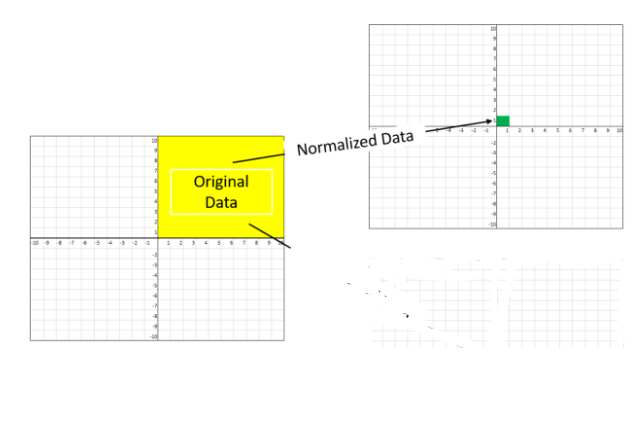

In [27]:
# Import the """MIN MAX SCALER"""
from sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler()

In [28]:
# Here the Features: Day of the Month, Distance, Temp, Precipitation (mm), Time for Pick up Arrival are picked 
# ... from the train data available. 
# Then, they are scaled and represented in a new Dataframe : df_train
df_train = pd.DataFrame(scaler.fit_transform(train[['Placement - Day of Month',
                                               'Distance (KM)', 'Temperature', 
                                               'Precipitation in millimeters', 'Time from Pickup to Arrival' ]]),
                   columns = ['Day of Month', 'Distance (km)', 'Temp', 'Precipitation (mm)', 'Pickup to Arrival (s)' ])

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
df_train.head()

,Day of Month,Distance (km),Temp,Precipitation (mm),Pickup to Arrival (s)
0,0.266667,0.062500,0.440191,0.0,0.094392
1,0.366667,0.312500,0.727273,0.0,0.252728
2,0.966667,0.041667,0.576980,0.0,0.057600
3,0.466667,0.166667,0.382775,0.0,0.170008
4,0.400000,0.166667,0.200957,0.0,0.153895


## Creating y and x metrics ##

<IPython.core.display.Javascript object>


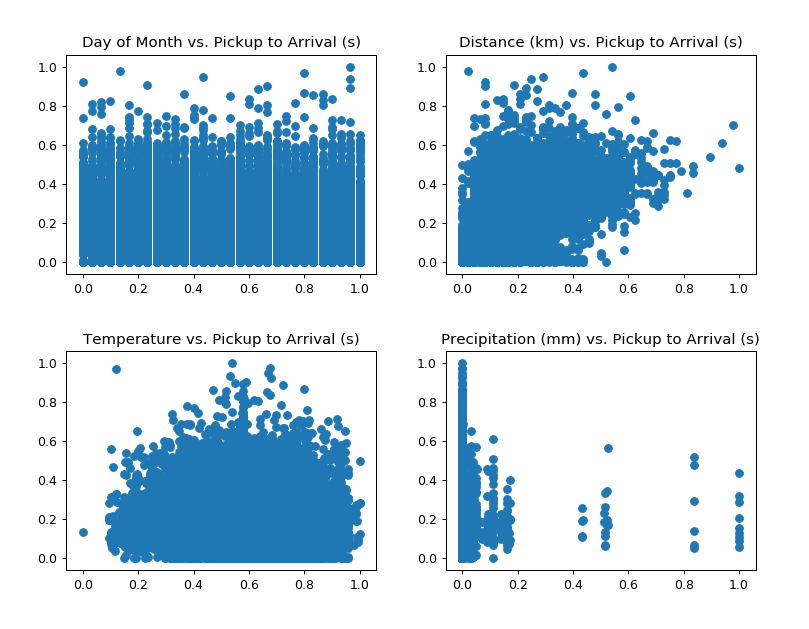

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(9,7))

axs[0,0].scatter(df_train['Day of Month'], df_train['Pickup to Arrival (s)'])
axs[0,0].title.set_text('Day of Month vs. Pickup to Arrival (s)')

axs[0,1].scatter(df_train['Distance (km)'], df_train['Pickup to Arrival (s)'])
axs[0,1].title.set_text('Distance (km) vs. Pickup to Arrival (s)')

axs[1,0].scatter(df_train['Temp'],df_train['Pickup to Arrival (s)'])
axs[1,0].title.set_text('Temperature vs. Pickup to Arrival (s)')

axs[1,1].scatter(df_train['Precipitation (mm)'], df_train['Pickup to Arrival (s)'])
axs[1,1].title.set_text('Precipitation (mm) vs. Pickup to Arrival (s)')

fig.tight_layout(pad=3.0)

plt.show()

# The Day of Month, Distance (km), Temp and precipitation represents the predictor, whereas, the Pickup 
# ... to Arrival is the response. 

## Spliting Data into the training and the test set ##

## Fitting the multivariate Regression model ##

## Assesing model accuracy ##